## Setup

To explore $TD(\lambda)$ in the tabular setting, we'll be working with the (slightly modified) Frozen Lake task again; see the $\texttt{Value Iteration and Policy Iteration}$ notebook for details.

In [22]:
import dill
#Import MDP object for Frozen Lake environment
with open('FrozenLakeMDP.pkl', 'rb') as input:
  mdp = dill.load(input)

In [23]:
# Some basic imports and setup
%matplotlib inline
import numpy as np, numpy.random as nr, gym, copy
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)

In [24]:
ALPHA = 1 #Discount factor

## TD($\lambda$) policy evaluation (NDP p.195 - 198)

In this section, we will implement the offline $TD(\lambda)$ algorithm for policy evaluation, discussed on pages 195-198 of the NDP book.  We'll look at the differences between the fist- and every-visit methods, as well as the effects of varying $\lambda$, as applied to the Frozen Lake task.   

In [25]:
def offlineTDL(alpha, lambda_, nEp, pi, everyVisit=False, stepExponent=-0.75, stepMultiplier=1):
  '''  
  Inputs
    alpha: discount factor
    lambda_: lambda from TD(lambda)
    mdp: MDP object
    nEp: number of episodes 
    pi: policy (function from s to a)
    everyVisit: boolean for everyVisit method
    stepExponent and stepMultiplier: 
      step size = stepMultiplier * (nEp + 1)**stepExponent
  Outputs
    VList: list of estimated V-functions from each episode
  '''
  VList = []            
  V = np.zeros(mdp.nS)  #Initialize value function 
  for ep in range(nEp):
    visitDict = {s:np.array([]) for s in range(mdp.nS)} #Counts steps since each visit to state
    Vupdate = np.zeros(mdp.nS)     #Accumulates TD errors at each state
    s = 0 #Start at top-left
    while True:     
        #Get next action, state, reward, and TD error
        a = pi(s)
        sp, r = mdp.step(s, a)
        d = r + alpha*V[sp] - V[s]
        
        #Add visit if first visit, or using every visit method
        if len(visitDict[s]) == 0 or everyVisit:
          visitDict[s] = np.append(visitDict[s], 0)       
        #Add to Vupdate 
        for s_ in range(mdp.nS):
          Vupdate[s_] += np.sum(lambda_**visitDict[s_]) * d  
          visitDict[s_] += np.ones(len(visitDict[s_]))
        s = sp 
        if s not in mdp.transient: 
          break 
    #Update V-function iterate
    stepSize = stepMultiplier*(nEp + 1)**stepExponent
    V += stepSize * Vupdate  
    VList.append(copy.copy(V))
  return np.array(VList)   

Next we'll test out the first- and every-visit variants of the algorithm, with varying values of $\lambda$, by evaluating a policy on the Frozen Lake task.  We'll evaluate the optimal policy, found using the $\texttt{policy_iteration}$ function I've defined in $\texttt{utils.py}$.  

After defining some functions to help us plot the V-function iterates at each episode, we run the algorithm for $\lambda \in \{0, 0.5, 0.9, 1 \}$ for both the first- and every-visit methods, and plot the results.

In [26]:
#Get policy to evaluate
#  policy_iteration returns list of V-functions and optimal policies from 
#  each iteration
from utils import policy_iteration, plot_policy
VList_PI, policyList_PI = mdp.policyIteration(alpha=ALPHA) 
pi = lambda s: policyList_PI[-1][s]

Recall that the optimal policy and corresponding state values look like this:

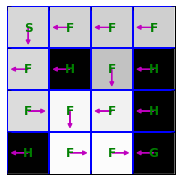

In [27]:
plot_policy(env, VList_PI[-1:], policyList_PI[-1:])

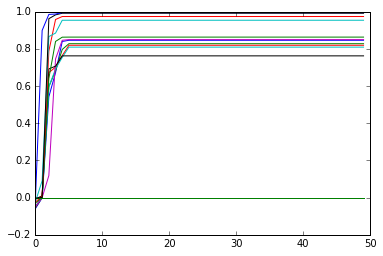

In [28]:
plt.plot(VList_PI)

In [29]:
def axisPlotter(ax, lambda_, VList): 
  title = 'Lambda = {}'.format(lambda_)    
  ax.set_xlabel('Episode')
  ax.set_ylabel('State value estimate')
  ax.set_title(title)
  for i in range(VList.shape[1]):
    ax.plot(VList[:,i], label=i)  

def plotVFs(alpha, everyVisit, lambdas, nEp, save=False):
  nlambda = len(lambdas)
  everyVisitStr = ['First Visit', 'Every Visit']
  print(everyVisitStr[everyVisit])
  fig, axes = plt.subplots(1, nlambda, sharex=True, sharey=True, figsize=(20,5))
  for j in range(nlambda):
    VList = offlineTDL(ALPHA, lambdas[j], nEp, pi, everyVisit=everyVisit)
    ax = axes[j] 
    axisPlotter(ax, lambdas[j], VList)
  ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0, title='State') 
  plt.tight_layout()
  plt.show()


In [30]:
ALPHA = 1
nEp = 1000
lambdas = [0, 0.5, 0.9, 1]

First Visit


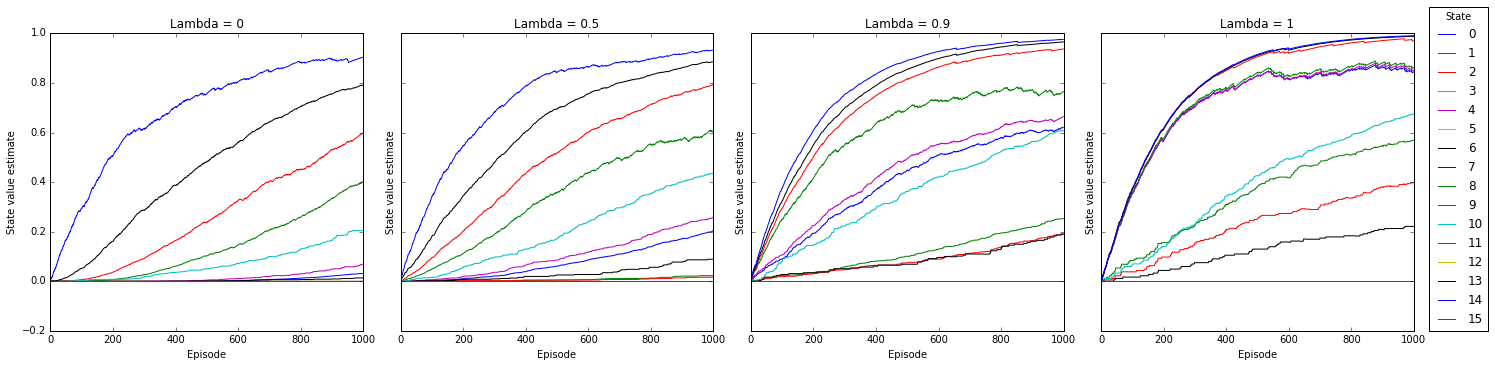

In [31]:
plotVFs(ALPHA, False, lambdas, nEp)

Every Visit


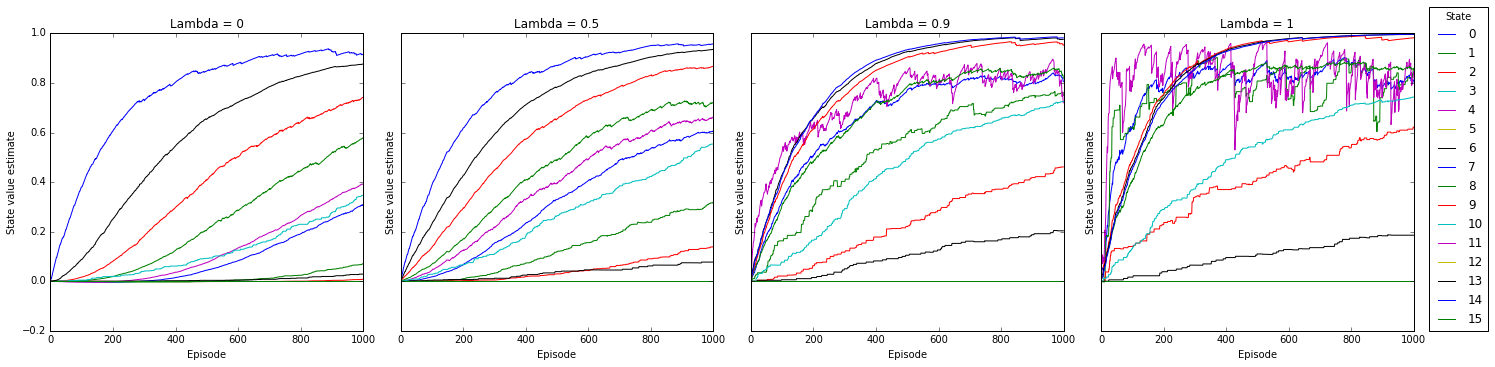

In [32]:
plotVFs(ALPHA, True,  lambdas, nEp)